[Flowers Dataset](https://www.kaggle.com/datasets/imsparsh/flowers-dataset) містить зображення 5 класів квітів: ромашка, кульбаба, троянда, соняшник, тюльпан.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**1. Отримання та попередня обробка даних**

Збираємо дані та створюємо окремі трансформації для train і test.

Для train додаємо аугментацію (random flip, crop), щоб fine-tuning був ефективнішим.

Для test — тільки resize + нормалізація.

Завантажуємо дані через ImageFolder.

Розбиваємо train/test у співвідношенні 80/20.

Створюємо відповідні DataLoader-и.

У результаті отримали:
- train_loader, test_loader — дані з відповідними трансформаціями,
- class_names — список класів (['daisy', 'dandelion', 'tulip']).

In [2]:
data_dir = '/content/drive/MyDrive/Colab Notebooks/Flowers'

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(128),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

full_dataset = datasets.ImageFolder(root=data_dir, transform=train_transform)
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size

train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])
test_dataset.dataset.transform = test_transform

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class_names = full_dataset.classes

**2. Побудова моделі ResNet18 для класифікації (3 класи)**

Завантажуємо ResNet18 із попередньо натренованими вагами на ImageNet

Заморожуємо всі шари моделі, тобто не дозволяємо змінювати їх під час навчання (це буде базовий варіант без повного fine-tuning)

Змінюємо останній шар (fc), щоб він видавав 3 класи замість 1000 (бо у нас daisy, dandelion, tulip)

Переносимо модель на пристрій (GPU або CPU)

Таким чином, я підготую модель для першого етапу навчання — feature extraction. Це і буде базова модель, з якою згодом я буду порівнювати результат після fine-tuning.

In [3]:
model = models.resnet18(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 3)

model = model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


**3. Тренування базової ResNet18 (без повного fine-tuning)**

Навчається тільки останній (новий) шар моделі, тобто модель працює у режимі feature extractor.

Усі шари ResNet18 заморожені, і їхні ваги не оновлюються.

Навчання відбувається на train_loader + після кожної епохи виводяться середня втрата loss та точність класифікації accuracy.

In [4]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.01)

num_epochs = 5
train_losses = []
train_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = 100 * correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")

Epoch 1/5, Loss: 0.8458, Accuracy: 72.70%
Epoch 2/5, Loss: 0.3667, Accuracy: 86.81%
Epoch 3/5, Loss: 0.2819, Accuracy: 88.60%
Epoch 4/5, Loss: 0.2881, Accuracy: 89.67%
Epoch 5/5, Loss: 0.2756, Accuracy: 89.59%


**4. Оцінка базової моделі на тестовому наборі**

Що тут відбувається:

- переведення моделі в режим оцінки (eval);

- "вимикання" градієнтів (torch.no_grad);

- подача тестових зображень та обчислення якості класифікації.

In [5]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_acc_before = 100 * correct / total
print(f"Test Accuracy before fine-tuning: {test_acc_before:.2f}%")

Test Accuracy before fine-tuning: 86.32%


**5. Повний fine-tuning моделі**

У цьому блоці:

1. Розморожено всі шари моделі (requires_grad = True).

2. Призначено новий оптимізатор, який оновлюватиме всі параметри моделі.

3. Повторення циклу навчання, тепер вже для fully trainable ResNet.

4. Навчання ще раз на тих же train даних.

In [6]:
for param in model.parameters():
    param.requires_grad = True

optimizer = optim.Adam(model.parameters(), lr=0.001)

finetune_losses = []
finetune_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = 100 * correct / total
    finetune_losses.append(epoch_loss)
    finetune_accuracies.append(epoch_acc)

    print(f"[Fine-tuning] Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")

[Fine-tuning] Epoch 1/5, Loss: 0.8521, Accuracy: 76.69%
[Fine-tuning] Epoch 2/5, Loss: 0.3720, Accuracy: 87.31%
[Fine-tuning] Epoch 3/5, Loss: 0.2003, Accuracy: 92.30%
[Fine-tuning] Epoch 4/5, Loss: 0.1780, Accuracy: 94.23%
[Fine-tuning] Epoch 5/5, Loss: 0.1638, Accuracy: 94.23%


**6. Оцінка точності після fine-tuning (тестовий набір)**

Виконуємо ту ж саму процедуру, що і раніше для базової моделі.

Передаємо новій, уже перенавченій, молелі ті ж тестові дані.

In [7]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_acc_after = 100 * correct / total
print(f"Test Accuracy after fine-tuning: {test_acc_after:.2f}%")

Test Accuracy after fine-tuning: 89.74%


**7. Візуалізація та порівняння до/після fine-tuning**

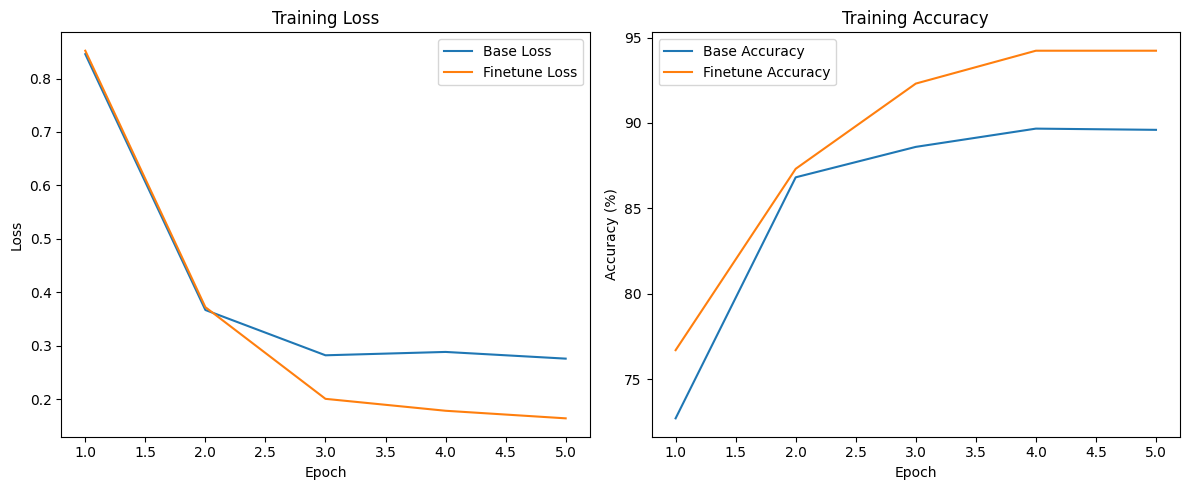

In [8]:
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Base Loss')
plt.plot(epochs, finetune_losses, label='Finetune Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Base Accuracy')
plt.plot(epochs, finetune_accuracies, label='Finetune Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

**9. Коротий підсумок**

Було реалізовано задачу тонкого налаштування (fine-tuning) попередньо натренованої моделі для задачі класифікації збражень квітів із датасету Flowers.
Як аархітектуру вибрано ResNet18, оскільки вона є CNN, добре адаптованою до візуальних задач.

На першому етапі модель працювала в режимі feature extractor: було заморожено всі шари ResNet18, крім останнього (fc), який було переналаштовано під класи задачі (daisy, dandelion та tulip).
У такому варіанті модель досягла тстової точності 86.32% після 5 епох навчання.

Далі було проведен fine-tuning: розморожено всі шари моделі та повторно навечено її на тому ж датасеті. Це дозволило адаптувати всю структуру мережі під конкретні дані.
Після fine-tuning тестова точність зросла до 89.74%. Отже, відбулося покарщення.